In [1]:
import numpy as np
import itertools
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-white')

## 데이터 불러오기 

In [2]:
sound = './sound data/ESC-50-master/meta/esc50.csv'

df = pd.read_csv(sound)
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [3]:
audio = []
target = []

for index, row in df.iterrows():
    audio_file = "./sound data/ESC-50-master/audio/" + row['filename']
    y, sr = librosa.load(audio_file, sr=None)
    audio.append(y)
    target.append(row['target'])

print(audio[:5])

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([-0.01184082, -0.10336304, -0.14141846, ...,  0.06985474,
        0.04049683,  0.00274658], dtype=float32), array([-0.00695801, -0.01251221, -0.01126099, ...,  0.215271  ,
       -0.00875854, -0.28903198], dtype=float32), array([0.53897095, 0.39627075, 0.26739502, ..., 0.09729004, 0.11227417,
       0.07983398], dtype=float32), array([-0.00036621, -0.0007019 , -0.00079346, ...,  0.00317383,
        0.00222778,  0.00158691], dtype=float32)]


In [4]:
print(target[:10])

[0, 14, 36, 36, 19, 19, 30, 34, 9, 30]


## 데이터 전처리 

In [40]:
import numpy as np

audio_np = np.array(audio, np.float32)
target_np =np.array(target, np.float32)

print(audio_np.shape, target_np.shape)

(2000, 220500) (2000,)


In [41]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(audio_np)

MinMaxScaler()

## MFCC

(20, 431)


/var/folders/n9/lhr4vj6d6fz4wh0vbnn7hz2h0000gn/T/ipykernel_1326/3735229544.py:1: FutureWarning: Pass y=[-0.01184082 -0.10336304 -0.14141846 ...  0.06985474  0.04049683
  0.00274658] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(audio_np[1], sr=sr)


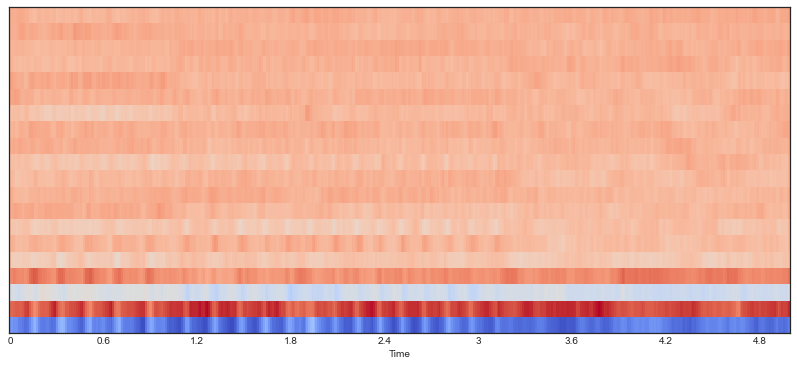

In [42]:
mfccs = librosa.feature.mfcc(audio_np[1], sr=sr)
print(mfccs.shape)

plt.figure(figsize=(14, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

## MFCC를 이용한 머신러닝 오디오 분류  

#### 데이터 준비 및 전처리

In [43]:
audio_mfcc = []
for y in audio:
  ret = librosa.feature.mfcc(y=y, sr=sr)
  audio_mfcc.append(ret)

In [44]:
mfcc_np = np.array(audio_mfcc, np.float32)
target_np = np.array(target, np.int16)

print(mfcc_np.shape, target_np.shape)

(2000, 20, 431) (2000,)


In [45]:
mfcc_np = mfcc_np.reshape(2000, 20 * 431)

In [46]:
from sklearn.preprocessing import MinMaxScaler

scaler =  MinMaxScaler()
scaler.fit(mfcc_np)

MinMaxScaler()

#### 학습 데이터 실험 데이터 분리 

In [47]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(mfcc_np, target_np, test_size=0.2)

print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(1600, 8620)
(400, 8620)
(1600,)
(400,)


#### Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_X, train_y)
pred = LR.predict(test_X)
acc = accuracy_score(pred, test_y)
print(acc)

0.345


/Users/seyilee/mambaforge/envs/ds_study/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Support Vector Machine

In [50]:
from sklearn import svm

SVM = svm.SVC(kernel='linear')
SVM.fit(train_X, train_y)
pred = SVM.predict(test_X)
acc = accuracy_score(pred, test_y)
print(acc)

0.4625


#### Decision Tree

In [51]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_X, train_y)
pred = DT.predict(test_X)
acc = accuracy_score(pred, test_y)
print(acc)

0.1625


### MFCC를 이용한 딥러닝 오디오 분류 
#### DNN 모델 

In [52]:
from tensorflow.keras.utils import to_categorical

mfcc_np = np.array(audio_mfcc, np.float32)
mfcc_np = mfcc_np.reshape((2000, 20*431))
mfcc_array = np.expand_dims(mfcc_np, -1)
inst_cat = to_categorical(target_np)

train_X, test_X, train_y, test_y = train_test_split(mfcc_array, inst_cat, test_size=0.2)

print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(1600, 8620, 1)
(400, 8620, 1)
(1600, 50)
(400, 50)


In [53]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense

def model_build():
  model = Sequential()

  input = Input(shape=(8620, ), name='input')
  output = Dense(512, activation='relu', name='hidden1')(input)
  output = Dense(256, activation='relu', name='hidden2')(output)
  output = Dense(218, activation='relu', name='hidden3')(output)
  output = Dense(50, activation='softmax', name='output')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['acc'])
  
  return model

In [54]:
model = model_build()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 8620)]            0         
                                                                 
 hidden1 (Dense)             (None, 512)               4413952   
                                                                 
 hidden2 (Dense)             (None, 256)               131328    
                                                                 
 hidden3 (Dense)             (None, 218)               56026     
                                                                 
 output (Dense)              (None, 50)                10950     
                                                                 
Total params: 4,612,256
Trainable params: 4,612,256
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(train_X, train_y, epochs=30, validation_split=0.2)

Epoch 1/30
 1/40 [..............................] - ETA: 12s - loss: 151.6761 - acc: 0.0000e+00

2022-07-09 11:23:28.139351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 18ms/step - loss: 126.0826 - acc: 0.0508 - val_loss: 27.9848 - val_acc: 0.0625
Epoch 2/30
 5/40 [==>...........................] - ETA: 0s - loss: 27.8123 - acc: 0.0813

2022-07-09 11:23:28.906803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 15ms/step - loss: 16.8843 - acc: 0.1242 - val_loss: 11.3275 - val_acc: 0.0844
Epoch 3/30
40/40 [==============================] - 1s 16ms/step - loss: 6.7878 - acc: 0.1602 - val_loss: 6.6605 - val_acc: 0.0719
Epoch 4/30
40/40 [==============================] - 1s 15ms/step - loss: 4.0291 - acc: 0.1625 - val_loss: 4.7816 - val_acc: 0.0594
Epoch 5/30
40/40 [==============================] - 1s 15ms/step - loss: 3.5469 - acc: 0.1625 - val_loss: 4.3388 - val_acc: 0.0781
Epoch 6/30
40/40 [==============================] - 1s 15ms/step - loss: 3.3074 - acc: 0.1930 - val_loss: 4.2331 - val_acc: 0.1219
Epoch 7/30
40/40 [==============================] - 1s 15ms/step - loss: 3.1033 - acc: 0.2297 - val_loss: 4.2188 - val_acc: 0.0906
Epoch 8/30
40/40 [==============================] - 1s 15ms/step - loss: 3.0535 - acc: 0.2383 - val_loss: 4.0848 - val_acc: 0.1531
Epoch 9/30
40/40 [==============================] - 1s 15ms/step - loss: 2.8493 - acc: 0.286

In [56]:
def plot_history(history_dict):
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(loss)+1)
  fig = plt.figure(figsize=(14, 5))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.plot(epochs, loss, 'b--', label='train_loss')
  ax1.plot(epochs, val_loss, 'r--', label='val_loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.grid()
  ax1.legend()

  acc = history_dict['acc']
  val_acc = history_dict['val_acc']

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.plot(epochs,  acc, 'b--', label='train_accuracy')
  ax2.plot(epochs, val_loss, 'r--', label='val_accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.grid()
  ax2.legend()

  plt.show()

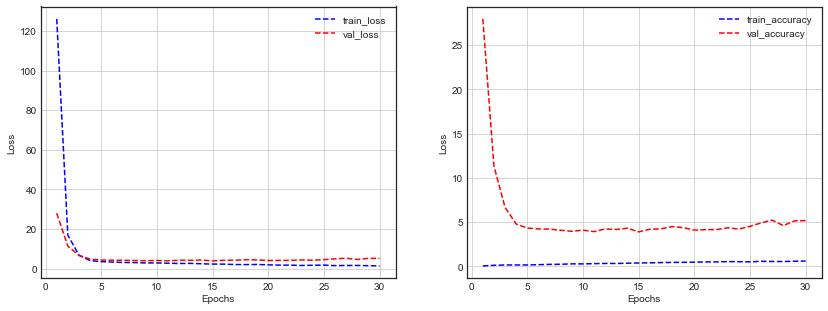

In [57]:
plot_history(history.history)

In [58]:
model.evaluate(test_X, test_y)

13/13 [==============================] - 0s 13ms/step - loss: 5.0761 - acc: 0.2475


2022-07-09 11:23:47.258118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[5.076147079467773, 0.2474999874830246]

#### CNN 모델

In [59]:
from tensorflow.keras.utils import to_categorical

mfcc_np = np.array(audio_mfcc, np.float32)
mfcc_array = np.expand_dims(mfcc_np, -1)
target_cat = to_categorical(target_np)

train_X, test_X, train_y, test_y = train_test_split(mfcc_array, target_cat, test_size=0.2)

print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(1600, 20, 431, 1)
(400, 20, 431, 1)
(1600, 50)
(400, 50)


In [60]:
from keras.layers import Conv2D, MaxPool2D, Flatten

def model_build():
  model =Sequential()

  input = Input(shape=(20, 431, 1))

  output = Conv2D(128, 3, strides=1, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(256, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(512, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Flatten()(output)
  output = Dense(512, activation='relu')(output)
  output = Dense(256, activation='relu')(output)
  output = Dense(128, activation='relu')(output)

  output = Dense(50, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)
  model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['acc'])
  return model


In [61]:
model = model_build()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 431, 1)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 431, 128)      1280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 216, 128)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 216, 256)      295168    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 108, 256)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 108, 512)       1180

In [62]:
history = model.fit(train_X, train_y, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20


2022-07-09 11:24:10.657362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 39.3756 - acc: 0.0258

2022-07-09 11:24:22.832033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 13s 1s/step - loss: 39.3756 - acc: 0.0258 - val_loss: 3.8953 - val_acc: 0.0344
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 3.8589 - acc: 0.0383 - val_loss: 3.7688 - val_acc: 0.0437
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 3.6443 - acc: 0.0703 - val_loss: 3.6103 - val_acc: 0.0781
Epoch 4/20
10/10 [==============================] - 12s 1s/step - loss: 3.3830 - acc: 0.1023 - val_loss: 3.4288 - val_acc: 0.1187
Epoch 5/20
10/10 [==============================] - 12s 1s/step - loss: 3.1038 - acc: 0.1617 - val_loss: 3.1436 - val_acc: 0.1750
Epoch 6/20
10/10 [==============================] - 12s 1s/step - loss: 2.7811 - acc: 0.2242 - val_loss: 2.8860 - val_acc: 0.2438
Epoch 7/20
10/10 [==============================] - 12s 1s/step - loss: 2.4563 - acc: 0.3172 - val_loss: 2.8596 - val_acc: 0.2531
Epoch 8/20
10/10 [==============================] - 12s 1s/step - loss: 2.2217 - acc: 0.3688 - val_l

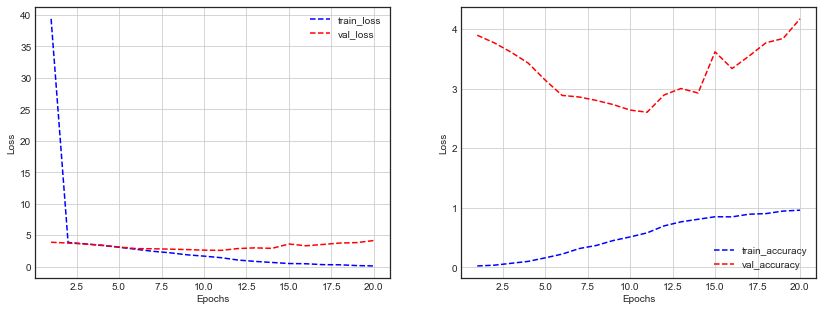

In [63]:
plot_history(history.history)

In [64]:
model.evaluate(test_X, test_y)

13/13 [==============================] - 1s 108ms/step - loss: 3.6227 - acc: 0.4125


[3.6227238178253174, 0.4124999940395355]